# Pulse Shaping

**Goal:** Demonstrate the operation of the pulse shaping block and analyze the spectrum of transmitted signals

**Steps:**

* We use modulated symbols as input to the pulse shaper
* Pulse shaping is described as upsampling and filtering
* The bandwidth of pulse-shaped signals is computed

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

In [2]:
## import functions from the `comms` package
# see prior notebook for details
from comms.sources import string_source, string_sink
from comms.mod_mapping import BPSK, QPSK, mod_mapper

## Pulse Shaping

Pulse shaping replaces each symbol with a pulse $p(t)$.
* After pulse-shaping the symbol sequence $s[n]$ is mapped to the signal:
$$
s(t) = \sum_n s[n] \cdot p(t-nT).
$$
* It is useful to think about construction of this signal in two steps:
 1. create a train of impulses
 $$
    d(t) = \sum_n s[n] \cdot \delta(t-nT)
 $$
 2. pass the impulses through a filter with impulse response $p(t)$.
   + this works because $\delta(t-nT) * p(t) = p(t-nT)$


### Pulse shaping in discrete time

This construction is easily implemented in discrete-time signal processing:

* Construct a discrete-time pulse $p[n]$ consisting of $f_sT$ samples per symbol period $T$.
  + $f_s$ is the sample rate
  + $fs_T$ is the number of samples per symbol period
  + this is also called the over-sampling factor.
* construct a discrete-time pulse $d[n]$ train by inserting $fsT-1$ zeros between symbols
* convolve the impulse train $d[n]$ and the pulse $p[n]$ to obtain the discrete-time pulse-shaped signal $s[n]$.
  + in an implementation of a communication system, $s[n]$ is passed to the A/D converter


#### A simple pulse

For our examples, let us consider the *sine squared* pulse:
$$
p(t) = \sqrt{\frac{8}{3T}} \sin^2(\pi t/T) \quad \text{for $0\leq t  < T$.}
$$

In discrete-time, $t=n/f_s$ and the discrete-time pulse is
$$
p[n] = \frac{1}{\sqrt{f_s}} p(n/f_s) = \sqrt{\frac{8}{3f_sT}} \sin^2(\pi n/(f_sT)) \quad \text{for $0\leq n  < f_sT$.}
$$
  + the factor $\sqrt{\frac{8}{3f_sT}}$ ensures that the energy of the pulse $\sum_n |p[n]|^2 = 1$ in discrete time.


In [3]:
def sine_squared_pulse(fsT):
    """synthesize a sine squared pulse
    
    Inputs:
    -------
    fsT: samples per symbol period

    Returns:
    --------
    pulse of length fsT samples
    """

    nn = np.arange(fsT)
    pp = np.sqrt(8/(3*fsT)) * np.sin(np.pi * nn/fsT)**2

    return pp

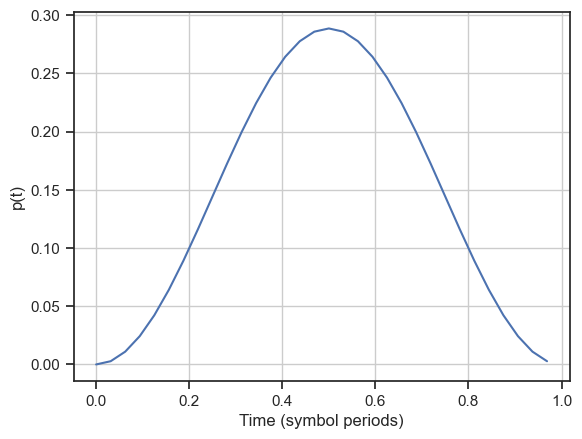

In [4]:
## plot the pulse shape at 32 samples per symbol period
T = 1
fs = 32
fsT = int(fs*T)

pp = sine_squared_pulse(fsT)
plt.plot(np.arange(fsT)/fs, pp)
plt.grid()

plt.xlabel('Time (symbol periods)')
plt.ylabel('p(t)')

plt.show()


### Making a pulse train

* Recall that the symbols are generated at the symbol rate $R=1/T$.
  - Each symbol lasts for $T$ seconds
* The pulse-shaped signal is a continuous-time signal; we approximate this signal in discrete-time.
  - this requires a sampling rate $f_s$ that is greater than $R$.
  - for simplicity, $f_s$ should be an integer multiple of $R$, i.e., $f_sT$ should be an integer
  - $fsT$ is the number of samples per symbol period
  - to approximate continuous time, we will often choose a large value for $fsT$, e.g., $fsT=32$
  - in an implementation, $fsT is usually 2 or 4.
* to convert from symbol rate $R$ to sample rate $f_s$, we insert $fsT-1$ zeros between symbols.

In [5]:
# make some information symbols
bits = string_source('Hi')
symbols = mod_mapper(bits, BPSK)
N_sym = len(symbols)

# upsample by fsT
fsT = 32
# make space for the signal; same type as the symbols
dd = np.zeros(fsT*N_sym, dtype=symbols.dtype)

# insert the symbols in the signal; up-sample
dd[0::fsT] = symbols


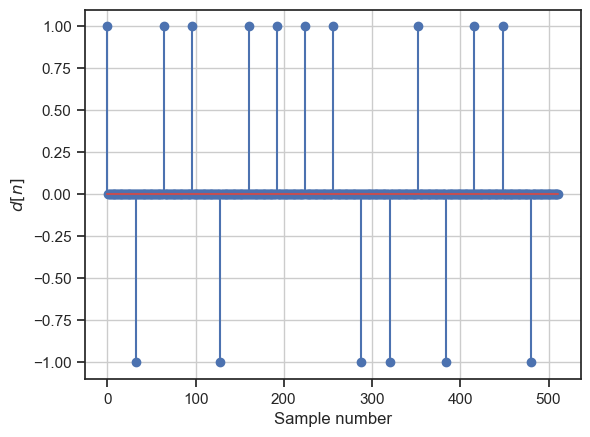

In [6]:
# plot the impulse train
plt.stem(dd.real)

plt.xlabel('Sample number')
plt.ylabel('$d[n]$')
plt.grid()

plt.show()

Note: the trailing zeros are not needed and will be eliminated later.

### Convolve with the pulse $p(t)$

The final step in pulse-shaping is to convolve the impulse train $d[n]$ with the pulse $p[n]$.

* this is easily done with the `np.convolve()` function

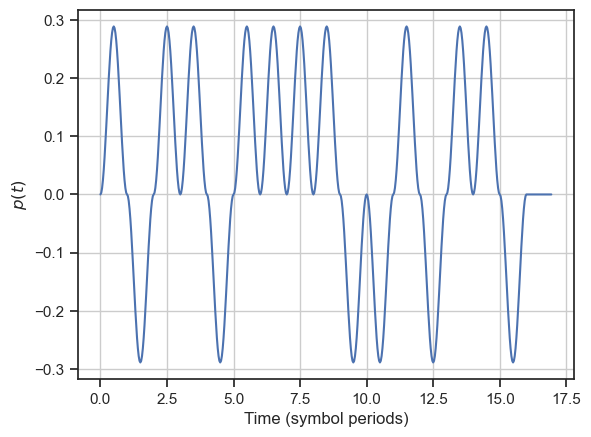

In [7]:
## convolve impulse train and pulse
sig = np.convolve(dd, pp)

# plot the impulse train
plt.plot(np.arange(len(sig))/fs, sig.real)

plt.xlabel('Time (symbol periods)')
plt.ylabel('$p(t)$')
plt.grid()

plt.show()

### Pulse shaping function

We wrap up the above discussion in a function that:
  * takes a number of symbols and
  * a pulse shape and
  * the oversapling factor $fsT$.

It produces a discrete-time version of the pulse-shaped signal $s(t)$.


In [8]:
def pulse_shape(syms, pp, fsT):
    """perform pulse shaping for a sequence of symbols"""

    # upsample the symbol sequence
    N_dd = (len(syms)-1) *fsT + 1  # this avoids extra zeros at end
    dd = np.zeros(N_dd, dtype=syms.dtype)
    dd[0::fsT] = syms

    # convolve with pulse
    return np.convolve(dd, pp)

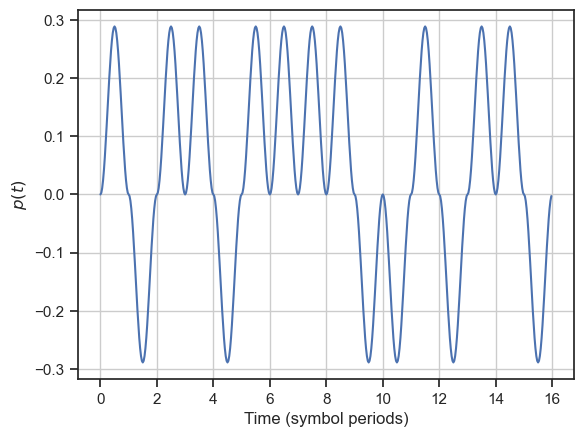

In [9]:
## verify that this worked
sig = pulse_shape(symbols, pp, fsT)

# plot the impulse train
plt.plot(np.arange(len(sig))/fs, sig.real)

plt.xlabel('Time (symbol periods)')
plt.ylabel('$p(t)$')
plt.grid()

plt.show()